In [4]:
from crpropa import *
from crpropa import Module
from MonopolePropagationBP import MonopolePropagationBP
from MonopolePropagationCK import MonopolePropagationCK
from MonopoleRadiation import MonopoleRadiation

In [5]:
from numpy import sqrt

#From Jackson Classical Electrodynamics, equation 14.27
#Energy radiated by particle in linear accelerator at each step
def analytical_radiation(max_time, number_steps, g, B, m, t):
    F = g * B
    E = mu0 * g**2 * F**2 * t  / 6 / M_PI / m**2 / c_light**3
    print("Correct: ", E[1])
    return E / eV

In [6]:
class MyTrajectoryOutput(Module):
    """
    Custom trajectory output: vx, vy, vz
    where i is a running cosmic ray number
    and x,y,z are the Galactocentric coordinates in [kpc].
    """
    def __init__(self, fname):
        Module.__init__(self)
        self.fout = open(fname, 'w')
    def process(self, c):
        A = c.getStepRadiation()
        E = c.current.getEnergy()
        self.fout.write(str(A) + '\n')
    def close(self):
        self.fout.close()

In [7]:
import time as Time

B = 1000*nG
direction_B = Vector3d(0, 0, 1)

m = 100*gigaelectronvolt/c_squared 
g = 1*gD

const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)


### Running the simulation with either CK or BP
def run_simulation(module, max_time, number_steps, g, B, m):
    direction = Vector3d(0, 0, 1)
    position = Vector3d(0, 0, 0)
    energy = 0*EeV

    c = Candidate(4110000, energy, position, direction, m, g)
    
    steplength = max_time/number_steps * c_light
    sim = ModuleList()
    if module == 'CK':
        sim.add(MonopolePropagationCK.MonopolePropagationCK(reg_field,1e-4,steplength, steplength))
        radiation_output = MyTrajectoryOutput('radiation_CK.txt')
    elif module == 'BP':
        sim.add(MonopolePropagationBP.MonopolePropagationBP(reg_field, steplength))
        radiation_output = MyTrajectoryOutput('radiation_BP.txt')
    else:
        print('no module found. Use either BP or CK.')
        return

    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_time*c_light))
    #add magnetic field
    sim.add(MonopoleRadiation.MonopoleRadiation(reg_field, False, 0, 0, 1))
    # each particle position will be saved in the above specified text field.
    sim.add(radiation_output)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    radiation_output.close()
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.1)


In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots_para(ax1, ax2, data, dE_ana, t, module, color):
    #numerical
    ax1.plot(t,data, markersize=0.01, marker='o',color = color, label=module)
    ax1.legend(markerscale=5)
    
    #analytical
    ax1.scatter(t,dE_ana,s=1, color = 'k', label='analytical')
    ax1.legend(markerscale=5)
    
    # compare with analytical solution
    comp = abs(data - dE_ana)/dE_ana*100
    ax2.scatter(t, comp,s=1, color = color, label=module)
    ax2.legend(markerscale=5)
    ax2.set_yscale('log')
    
def plot_figure_para(max_time, number_steps, g, B, m):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))

    # calculate the time stamps similar to that used in the numerical simulation
    data1 = load_radiation('radiation_BP.txt')
    data2 = load_radiation('radiation_CK.txt')
        
    t = np.linspace(0, max_time, len(data2))
    dE = analytical_radiation(max_time, number_steps, g, B, m, t)
    dE_ana = np.full((1, len(data2)), dE)

    plot_subplots_para(ax1, ax2, data1, dE_ana, t, 'BP', 'brown')
    plot_subplots_para(ax3, ax4, data2, dE_ana, t, 'CK', 'dodgerblue')
    
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$E$ [eV]')
    ax1.set_title('Cumulative Energy Loss vs. Time', fontsize=18)
    
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('$error$ [%]')
    ax2.set_title('Relative error vs. time', fontsize=18)
    
    ax3.set_xlabel('$t$ [s]')
    ax3.set_ylabel('$E$ [eV]')
    ax4.set_xlabel('t [s]')
    ax4.set_ylabel('$error$ [%]')
    
    fig.tight_layout()
    plt.show()

In [27]:
import pandas as pd

def load_radiation(text):
    E = np.genfromtxt(text, unpack=True, skip_footer=1)
    E = np.cumsum(E)
    return E / eV

Simulation time with module CK is 0.06223487854003906s.
Simulation time with module BP is 0.0982828140258789s.
Correct:  9.40304554468184e-29


/tmp/ipykernel_4047/2511422161.py:14: RuntimeWarning: divide by zero encountered in divide
  comp = abs(data - dE_ana)/dE_ana*100


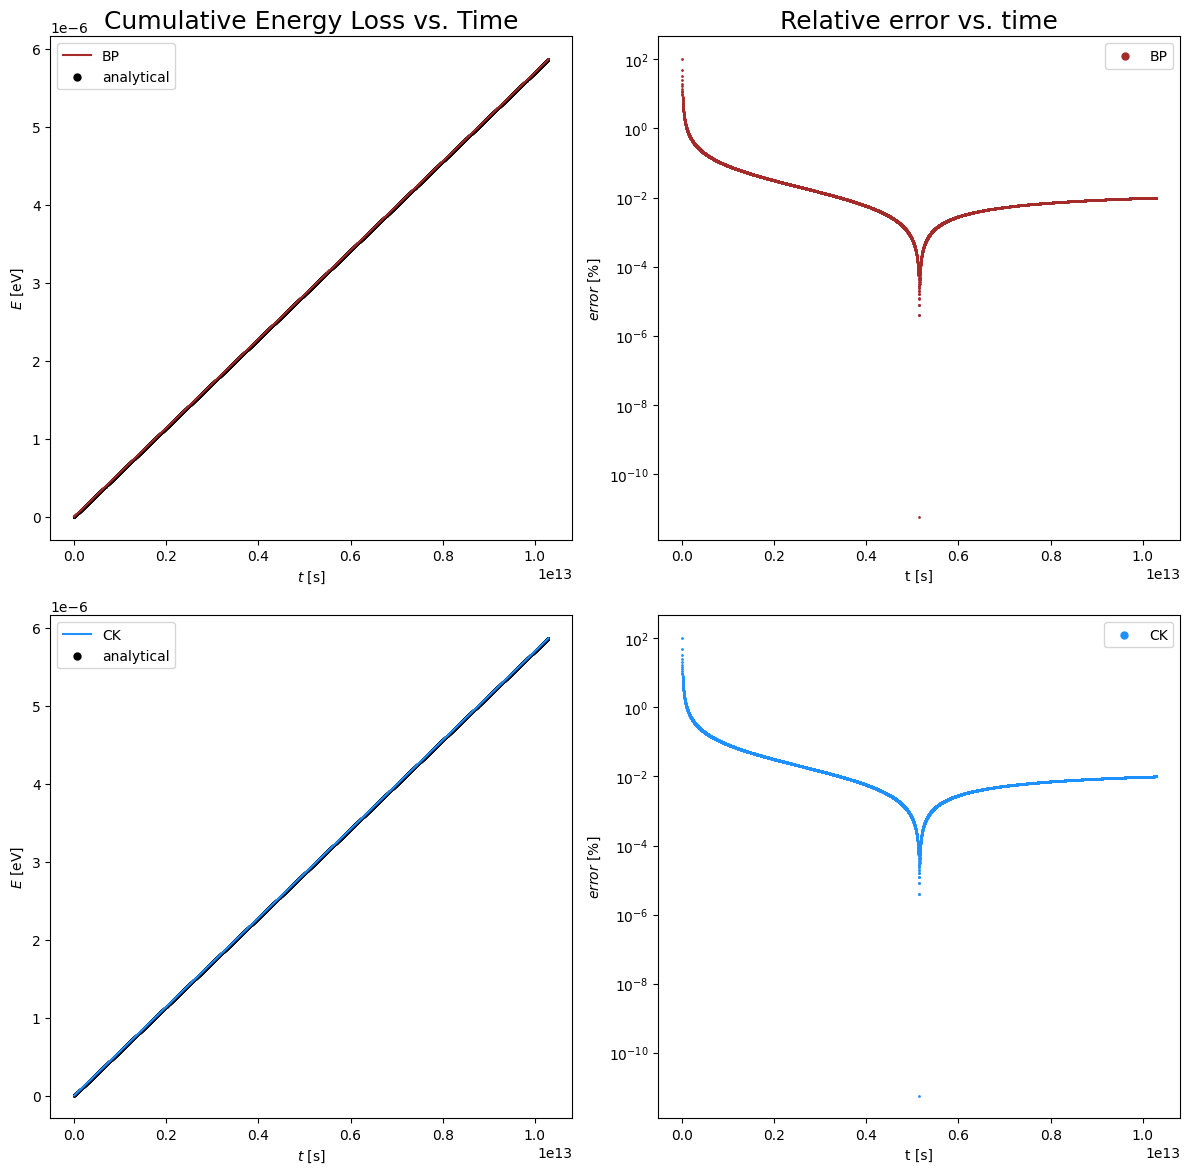

In [28]:
max_dist = 100*kpc
max_time = max_dist / c_light
number_steps = 10000
run_simulation('CK', max_time, number_steps, g, B, m)
run_simulation('BP', max_time, number_steps, g, B, m)
plot_figure_para(max_time, number_steps, g, B, m)